In [1]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '10'

In [2]:
!pwd

/Users/marcoghezzi/PycharmProjects/pythonProject/fear_gen/simulation


In [3]:
import os
#os.chdir('./simulation')

In [4]:
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import r2_score

from env import TrialEnv

In [5]:
from fear_gen import extract_correct_csv

In [6]:
trials = 144
steps = 2  # number of timepoints per trial

STATES
state if the img is cs+ or cs-

In [7]:
context = ['cs+', 'cs-']
choice = ['guess cs+','guess cs-']
#error = ['low', 'high']

OBSERVATIONS

morphing level binary. shock only if morph_level=6

In [8]:
morph_level_obs = ['0','1']
# the subject receive the electric shock?
shock_obs = ['shock','no_shock','null']
# observation to discriminate if the subject is surprised or prepared. A sort of diff between user prediction and shock observation
surprised_obs = ['not_surprised','surprised','null']

ACTIONS<br>
the subject predict if should be receive the shock or not

In [9]:
context_action = ['do_nothing']
choice_action = ['guess cs+','guess cs-']

Define `num_states` and `num_factors` below

In [10]:
num_states = [len(context), len(choice)] #[2,2]
num_factors = len(num_states) #2

define `num_obs` and `num_modalities` below

In [11]:
num_obs = [len(morph_level_obs), len(shock_obs), len(surprised_obs)] # [2,2,2]
num_modalities = len(num_obs) #3

In [12]:
def matrices():
    """
    The A, B, C, D, E matrices are built.
    """
    # This is the likelihood mapping that truly describes the relationship between the
    # environment's hidden state and the observations the agent will get

    # A matrix
    # A dimension?
    A = utils.obj_array(num_modalities)
    A_morph = np.zeros((len(morph_level_obs), len(context), len(choice)))
    A_shock = np.zeros((len(shock_obs), len(context), len(choice)))
    A_surprise = np.zeros((len(surprised_obs), len(context), len(choice)))
    for j in range(len(choice)):
        # mor_lev_binary/states #cs+ #cs-
        A_morph[:,:,j] = np.array([[0, 1],    #img or
                                   [1, 0]])   #img minac
        #shock-noshock/states
        A_shock[:,:,j] = np.array([[0.75, 0],
                                   [0.25, 1],
                                   [0, 0]])
        #surprise/states
        A_surprise[:,j,j] = np.array([1,0,0])
        A_surprise[:,j,int(not j)] = np.array([0, 1, 0])
    A[0] = A_morph
    A[1] = A_shock
    A[2] = A_surprise

    # B matrix
    # The transition mapping that truly describes the environment's dynamics

    #B as an identity matrix. no state transitions
    B = utils.obj_array(num_factors)
    B_context = np.zeros((len(context), len(context), len(context_action)))
    B_context[:,:,0] = np.eye(len(context))
    #B_context[:,:,2] = np.eye(len(context))
    B_choice = np.zeros((len(choice), len(choice), len(choice_action)))
    for choice_i in range(len(choice)):
        B_choice[choice_i, :, choice_i] = 1.0
    B[0]=B_context
    B[1]=B_choice

    # This is the matrix representing the preferences over outcomes
    #prepared-surprised/cs+-
    C = utils.obj_array_zeros(num_obs)          #num modalities
    C[0] = np.zeros(2)
    C[1] = np.zeros(3)
    C[2] = np.array([2,-3,0])
    return A, B, C

true data


In [13]:
def load_data(columns=[], binary_morphing_level=False, shock_as_int = False,subject_number=0,remove_first_trials=None,remove_last_trials=None):
    '''
    Function that read NewLookAtMe files and extract
    :param columns:
    :param binary_morphing_level:
    :param shock_as_int:
    :param subject_number:
    :return:
    '''

    df = pd.read_csv('../data/newLookAtMe/newLookAtMe01.csv')
    df = df.filter(columns)

    if 'morphing level' in columns and binary_morphing_level:
        df['morphing level'] = [int(d==6) for d in df['morphing level']]
    if 'shock' in columns and shock_as_int:
        df['shock'] = df['shock'].astype(int)
    if remove_first_trials is not None:
        df = df[remove_first_trials:]
        df.reset_index(drop=True,inplace=True)
    return df

In [14]:
data= load_data(columns=['morphing level','shock','rating'] ,binary_morphing_level=True, shock_as_int = True,remove_first_trials=16)

In [15]:
rating_subj = data['rating']
data = data.drop(columns='rating')

fake data generation

In [16]:
morphing_levels = [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10
shocks = [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10
fake_data_4_75 = pd.DataFrame({'morphing level': morphing_levels, 'shock': shocks})

# Select rows where both columns are equal to 1
mask = (fake_data_4_75['morphing level'] == 1) & (fake_data_4_75['shock'] == 1)

# Select % of those rows at random
sampled_indices = np.random.choice(fake_data_4_75[mask].index, size=int(len(fake_data_4_75[mask]) * 0.5), replace=False)

# Set the values in those rows to (1,0)
fake_data_4_75.loc[sampled_indices, 'shock'] = 0


In [17]:
morphing_levels = [0] * 50 + [1] * 50
shocks = [0] * 50 + [1] * 50
fake_data_half = pd.DataFrame({'morphing level': morphing_levels, 'shock': shocks})

define an agent<br>


In [18]:
E = utils.obj_array(1)
E[0] = np.array([.4,.2,.4])
A,B,C = matrices()
my_agent = Agent(A=A, B=B, C=C, gamma=0.5)
qs0 = my_agent.qs
# define an environment
my_env = TrialEnv(data=data)
list_qs = []
list_action = []

In [19]:
initial_action = 'first_action'

iterate over all trials

In [20]:
list_action = []
list_qs = []
list_policies_low = []
list_policies_high = []
for trial in range(trials):

    print("\n-----TRIAL " + str(trial) + " ------")

    agent_stimul_obs, agent_shock_obs, agent_surpr_obs = 'null', 'null', 'null'
    agent_stimul_obs = my_env.get_observation(param='morphing level', trial_number=trial)
    print('observation (t=0): ', agent_stimul_obs, agent_shock_obs, agent_surpr_obs)
    obs = [morph_level_obs.index(agent_stimul_obs), shock_obs.index(agent_shock_obs),
            surprised_obs.index(agent_surpr_obs)]

    qs = my_agent.infer_states(obs)  # agent update beliefs about hidden states given observations
    print('beliefs over states (t=0):', qs[0]*100)
    list_qs.append(qs[0])


    policies = my_agent.infer_policies()  # inferring policies and sampling actions from the posterior
    agent_action = my_agent.sample_action()

    action_name = choice_action[int(agent_action[1])]

    print('beliefs over actions: ', policies[0]*100)
    list_policies_low.append(policies[0][0])
    list_policies_high.append(policies[0][1])
    print('action: ', action_name)
    list_action.append(action_name)

    agent_surpr_obs = my_env.step(action_name, trial)
    agent_shock_obs = my_env.get_observation(param='shock', trial_number=trial)

    print('observation (t=1): ', agent_stimul_obs, agent_shock_obs, agent_surpr_obs)

    obs = [morph_level_obs.index(agent_stimul_obs), shock_obs.index(agent_shock_obs),
           surprised_obs.index(agent_surpr_obs)]
    qs = my_agent.infer_states(obs)  # agent update beliefs about hidden states given observations
    print('beliefs over states (t=1):', qs[0] * 100)
    #my_agent.reset()


-----TRIAL 0 ------
observation (t=0):  1 null null
beliefs over states (t=0): [50. 50.]
beliefs over actions:  [50. 50.]
action:  guess cs+
observation (t=1):  1 shock not_surprised
beliefs over states (t=1): [1.00000000e+02 1.33333333e-14]

-----TRIAL 1 ------
observation (t=0):  0 null null
beliefs over states (t=0): [1.00000000e+02 2.33333333e-14]
beliefs over actions:  [92.414182  7.585818]
action:  guess cs+
observation (t=1):  0 no_shock surprised
beliefs over states (t=1): [23.07692308 76.92307692]

-----TRIAL 2 ------
observation (t=0):  0 null null
beliefs over states (t=0): [23.07692308 76.92307692]
beliefs over actions:  [20.64998823 79.35001177]
action:  guess cs-
reward
observation (t=1):  0 no_shock not_surprised
beliefs over states (t=1): [3.e-15 1.e+02]

-----TRIAL 3 ------
observation (t=0):  1 null null
beliefs over states (t=0): [1.3e-14 1.0e+02]
beliefs over actions:  [ 7.585818 92.414182]
action:  guess cs-
penalty
observation (t=1):  1 shock surprised
beliefs ov

In [21]:
list_csplus=[]
list_csminus=[]
for index, value in enumerate(list_qs):
    list_csplus.append(value[0])
    list_csminus.append(value[1])
    #print('trial:',(index),'',value[0], '  ',value[1])

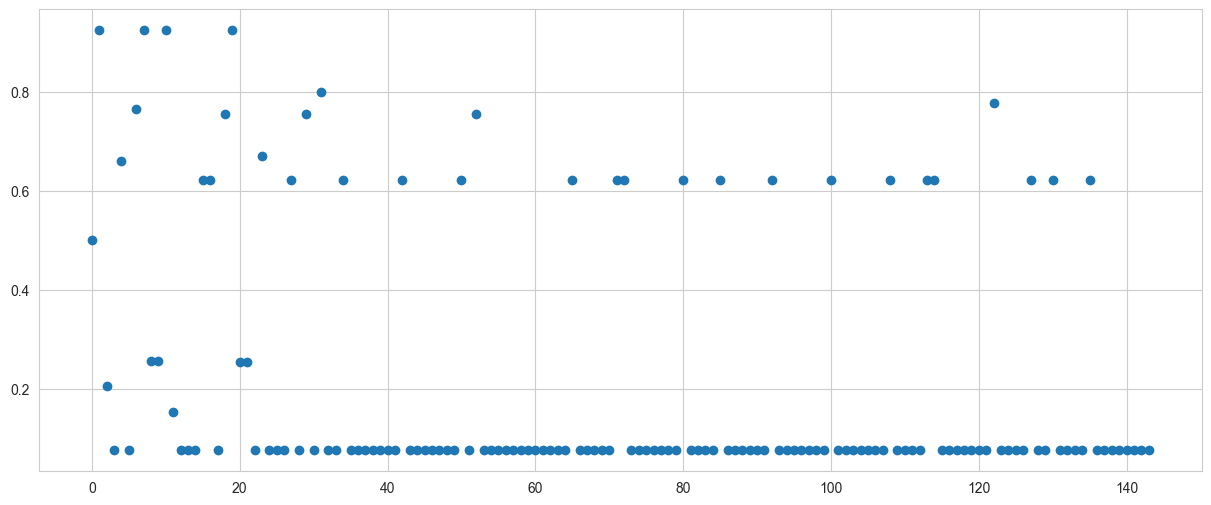

In [22]:
plt.figure(figsize=(15,6))
plt.scatter(np.arange(len(list_policies_low)),list_policies_low)

In [23]:
list_policies_high

[0.5,
 0.07585818002124417,
 0.7935001177462643,
 0.9241418199787558,
 0.33958646373987594,
 0.9241418199787558,
 0.23468508813980232,
 0.07585818002124417,
 0.743088693435606,
 0.7430886934170218,
 0.07585818002124431,
 0.8464113992947637,
 0.9241418199787559,
 0.9241418199787558,
 0.9241418199787558,
 0.377540668798145,
 0.3775389361105867,
 0.9241418199787558,
 0.2458828943219478,
 0.07585818002124417,
 0.7454821254909944,
 0.7454821254741844,
 0.9241418199787558,
 0.32878617276985633,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.377540668798145,
 0.9241418199787558,
 0.2458833820069041,
 0.9241418199787558,
 0.20082936265386558,
 0.9241418199787558,
 0.9241418199787558,
 0.377540668798145,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.377540668798145,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9241418199787558,
 0.9

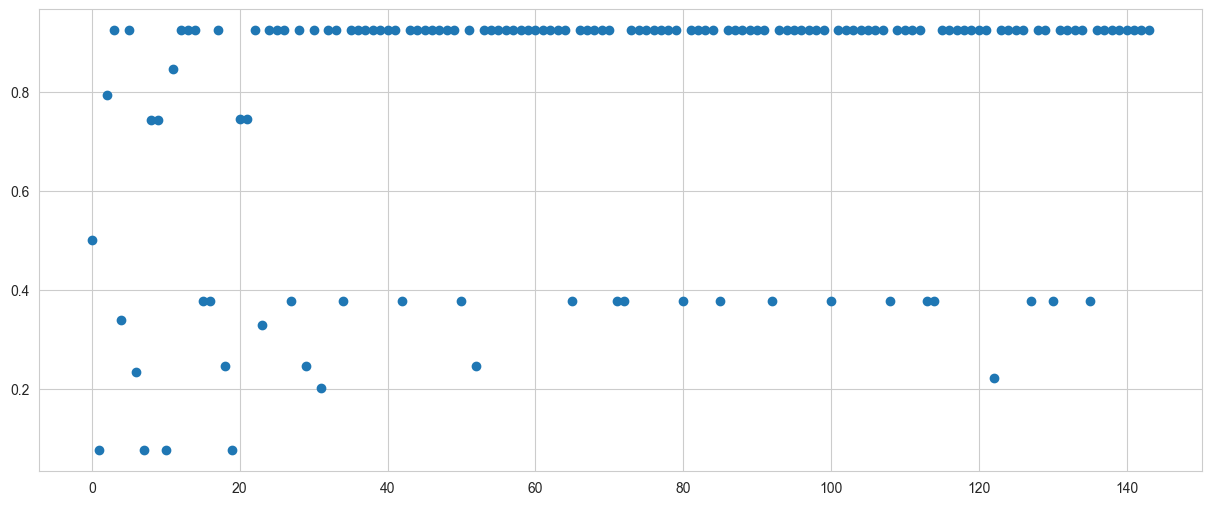

In [24]:
plt.figure(figsize=(15,6))
plt.scatter(np.arange(len(list_policies_high)),list_policies_high)

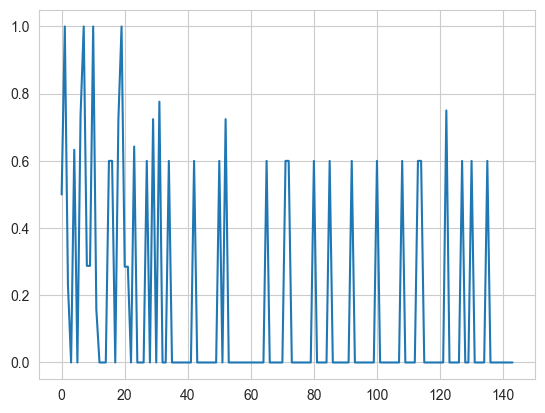

In [25]:
plt.plot(list_csplus)

In [26]:
y=[]
for index, value in enumerate(list_action):
    if value=='guess cs-':
        y.append(0)
    if value=='guess cs+':
        y.append(1)


In [27]:
data

,morphing level,shock
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
139,0,0
140,0,0
141,0,0
142,0,0


In [28]:
y

[1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [29]:
np.corrcoef(y,data['shock'])

array([[ 1.        , -0.13599595],
       [-0.13599595,  1.        ]])

In [30]:
data_for_plot = data

"for i in range(1, 10):\n    plt.axvline(x=10*i, color='orange')"

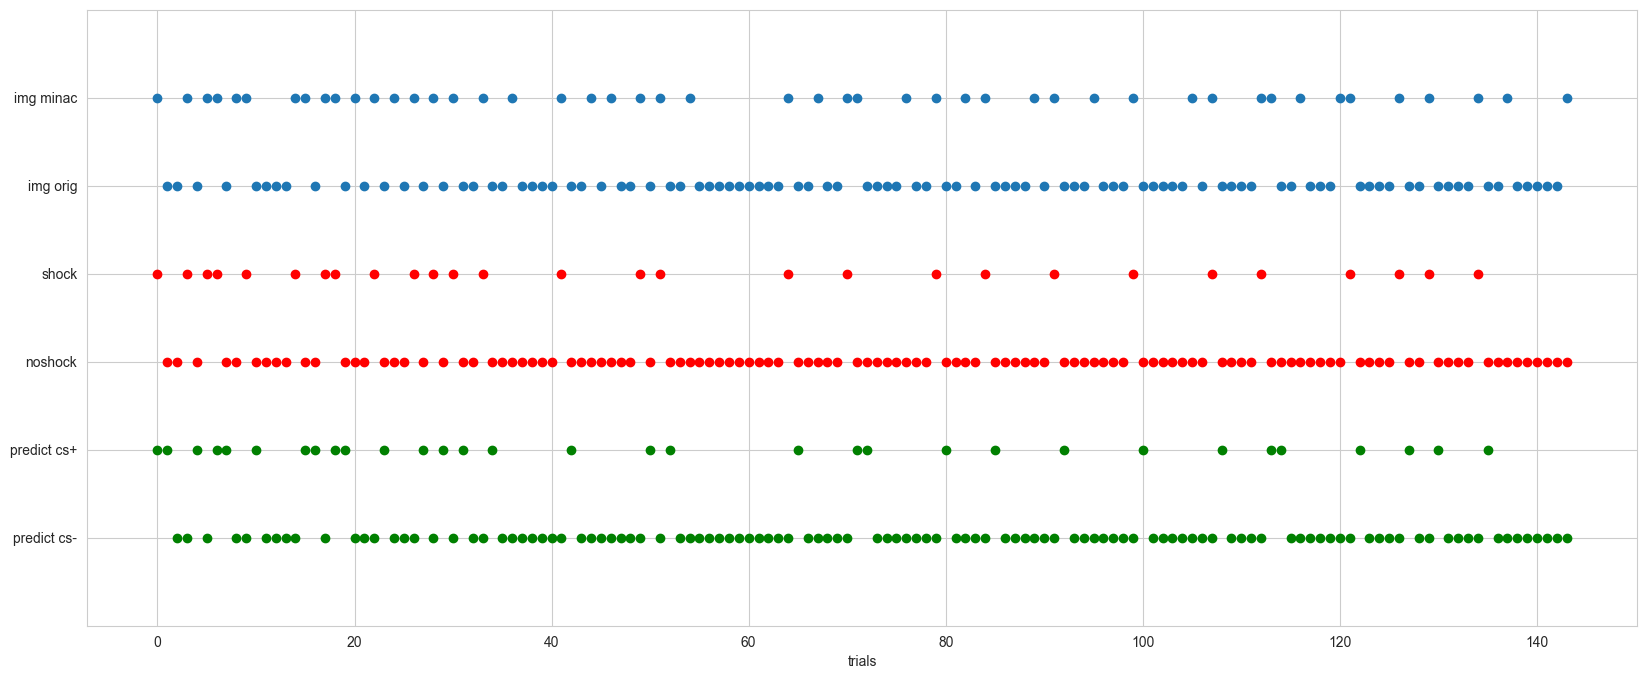

In [31]:
fig = plt.figure(figsize=(20,8))
plt.ylim(-1,6)
plt.yticks(ticks=(0,1,2,3,4,5),labels=('predict cs-','predict cs+','noshock','shock','img orig','img minac'))
plt.xlabel('trials')
plt.scatter(np.arange(len(data_for_plot['morphing level'])),data_for_plot['morphing level']+4)
plt.scatter(np.arange(len(data_for_plot['shock'])),data_for_plot['shock']+2,color='red')
plt.scatter(np.arange(len(y)),y,color = 'green')
'''for i in range(1, 10):
    plt.axvline(x=10*i, color='orange')'''

In [44]:
plt.rcParams['axes.grid'] = False

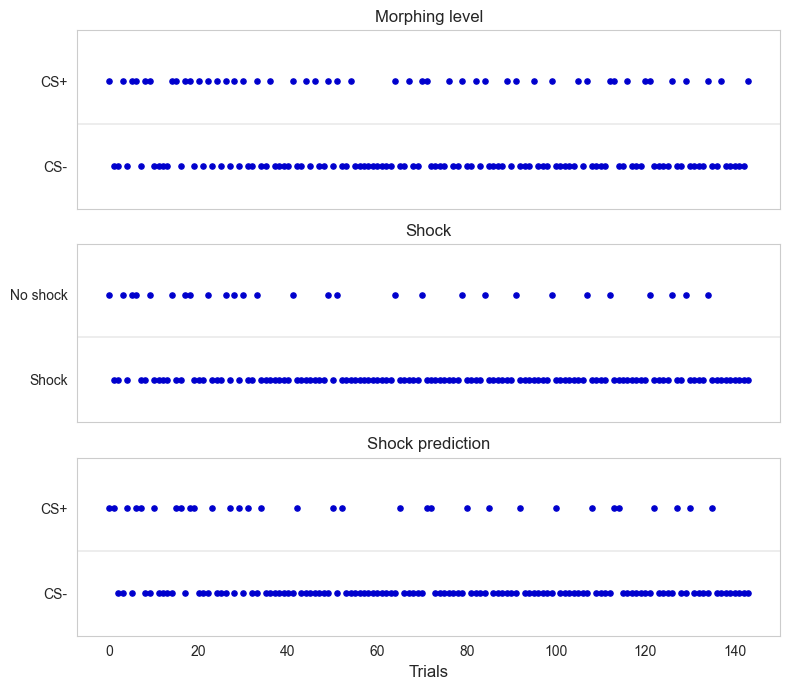

In [58]:
fig, ax = plt.subplots(3, figsize=(8,7), sharex=True)



ax[0].set_title('Morphing level')
ax[0].scatter(np.arange(len(data['morphing level'])),data['morphing level'], color='mediumblue', s=14)
ax[0].set_yticks(np.arange(0, 2), ['CS-', 'CS+'])
ax[0].axhline(y=0.5, color='gray', linewidth=0.2)
ax[0].set_ylim([-0.5, 1.6])
ax[0].set_xticks(np.arange(0, 150, 20), )

ax[1].set_title('Shock')
ax[1].scatter(np.arange(len(data['shock'])),data['shock'],color='mediumblue', s=14)
ax[1].set_yticks(np.arange(0, 2), ['Shock', 'No shock'])
ax[1].axhline(y=0.5, color='gray', linewidth=0.2)
ax[1].set_ylim([-0.5, 1.6])
ax[1].set_xticks(np.arange(0, 150, 20), )


ax[2].set_title('Shock prediction')
ax[2].scatter(np.arange(len(y)),y, color='mediumblue', s=14)
ax[2].set_yticks(np.arange(0, 2), ['CS-', 'CS+'])
ax[2].axhline(y=0.5, color='gray', linewidth=0.2)
ax[2].set_ylim([-0.5, 1.6])
ax[2].set_xticks(np.arange(0, 145, 20))
plt.xlabel('Trials', fontsize='12')

fig.tight_layout()
plt.show()


In [34]:
len(y)

144

In [35]:

'''
img4.set_title('Selected policies (post-trial)')
img4.set(ylabel=r'$\pi$')
img4.set_ylim(max(y4), min(y4))
for line in range(0, 12):
    img4.axhline(y=line, color='gray', linewidth=0.2)
img4.axvline(x=32, color='mediumaquamarine', label='context reversal', linestyle='dotted')
img4.set_xticks(np.arange(0, 65, 4), [])  # set text labels
img4.set_yticks(np.arange(0, 11, 1),
                [r'$\bigcirc\bigcirc$', r'$\bigcirc\leftarrow$', r'$\bigcirc\rightarrow$', r'$\bigcirc\downarrow$',
                 r'$\leftarrow\leftarrow$', r'$\rightarrow\rightarrow$', r'$\downarrow\bigcirc$',
                 r'$\downarrow\leftarrow$', r'$\downarrow\rightarrow$', r'$\downarrow\downarrow$', ''])
img4.plot(x, y4, 'o', markeredgewidth=0.1, markerfacecolor=None, color='mediumblue')'''

"\nimg4.set_title('Selected policies (post-trial)')\nimg4.set(ylabel=r'$\\pi$')\nimg4.set_ylim(max(y4), min(y4))\nfor line in range(0, 12):\n    img4.axhline(y=line, color='gray', linewidth=0.2)\nimg4.axvline(x=32, color='mediumaquamarine', label='context reversal', linestyle='dotted')\nimg4.set_xticks(np.arange(0, 65, 4), [])  # set text labels\nimg4.set_yticks(np.arange(0, 11, 1),\n                [r'$\x08igcirc\x08igcirc$', r'$\x08igcirc\\leftarrow$', r'$\x08igcirc\rightarrow$', r'$\x08igcirc\\downarrow$',\n                 r'$\\leftarrow\\leftarrow$', r'$\rightarrow\rightarrow$', r'$\\downarrow\x08igcirc$',\n                 r'$\\downarrow\\leftarrow$', r'$\\downarrow\rightarrow$', r'$\\downarrow\\downarrow$', ''])\nimg4.plot(x, y4, 'o', markeredgewidth=0.1, markerfacecolor=None, color='mediumblue')"

In [36]:
pymdp_agent = np.array(y)

df_correlation = pd.DataFrame(columns=['subject','pearson','r2score','cohen'])


os.chdir('..')
valid_sub = extract_correct_csv.extract_only_valid_subject()
for sub in valid_sub:
    subj_ = extract_correct_csv.read_correct_subject_csv(sub)
    df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')

    df_sub = df_sub[['shock', 'rating', 'morphing level']]

    df_sub['shock'] = df_sub['shock'].astype(int)
    df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
    df_sub['rating'] = df_sub['rating'].replace([1, 2], [0, 0])
    df_sub['rating'] = df_sub['rating'].replace([3,4,5], [1,1,1])

    # remove habituation trials
    df_sub_learn = df_sub[16:]

    rating_sub = np.array(df_sub_learn['rating'])

    # remove nan
    bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(pymdp_agent))
    rating_sub_ = np.compress(bad, rating_sub)
    rating_rational_ = np.compress(bad, pymdp_agent)
    rating_sub_ = [int(x) for x in rating_sub_]

    #pearson corr coeff
    pearson = round(np.corrcoef(rating_sub_,rating_rational_)[0][1],2)

    #r2 score
    r2 = round(r2_score(rating_sub_,rating_rational_),2)

    #cohen kappa
    cohen = round(cohen_kappa_score(rating_sub_,rating_rational_),2)

    # write line
    df_tmp = pd.DataFrame({'subject':sub,'pearson':pearson,'r2score':r2,'cohen':cohen},index=np.arange(1))
    df_correlation = pd.concat([df_correlation,df_tmp])

# read sias data
sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
sias_df['subject'] = [float(x) for x in sias_df['subject']]

# read lds data
lds_df = pd.read_csv('data/lds_subjects.csv')
lds_df['subject'] = [float(x) for x in lds_df['subject']]

# merge sias,lds and correlation indices
merged_df = pd.concat([sias_df.set_index('subject'), lds_df.set_index('subject'), df_correlation.set_index('subject')], axis=1)
merged_df = merged_df.reset_index().dropna()

#extract low and high lds
lds_ = merged_df.sort_values('lds').reset_index(drop=True)
lower_lds = lds_[:7]
higher_lds = lds_[-7:]

#extract low and high sias
sias_ = merged_df.sort_values('sias_score').reset_index(drop=True)
lower_sias = sias_[:7]
higher_sias = sias_[-7:]


In [37]:
merged_df.to_csv('output/simulation_pymdp/correlation.csv', index=False)

# compare low vs high lds

In [38]:
lower_lds.median().drop(['subject','sias_score','lds'])

pearson   -0.09
r2score   -1.32
cohen     -0.07
dtype: float64

In [39]:
higher_lds.median().drop(['subject','sias_score','lds'])

pearson   -0.17
r2score   -1.16
cohen     -0.16
dtype: float64

# compare low vs high sias

In [40]:
lower_sias.median().drop(['subject','sias_score','lds'])

pearson   -0.12
r2score   -1.26
cohen     -0.11
dtype: float64

In [41]:
higher_sias.median().drop(['subject','sias_score','lds'])

pearson   -0.10
r2score   -1.12
cohen     -0.08
dtype: float64

In [42]:
merged_df

,subject,sias_score,lds,pearson,r2score,cohen
0,1.0,21.0,0.201,0.05,-0.79,0.04
1,2.0,11.0,0.828,-0.22,-1.34,-0.18
3,4.0,12.0,0.111,-0.09,-1.32,-0.07
4,5.0,30.0,0.953,-0.06,-1.01,-0.05
5,6.0,8.0,1.312,-0.21,-1.26,-0.20
6,7.0,25.0,0.535,-0.10,-1.12,-0.08
12,13.0,16.0,0.141,-0.05,-1.39,-0.04
14,15.0,16.0,0.693,-0.13,-1.06,-0.12
15,16.0,55.0,0.621,-0.12,-1.16,-0.10
16,17.0,16.0,-0.382,-0.19,-1.60,-0.14


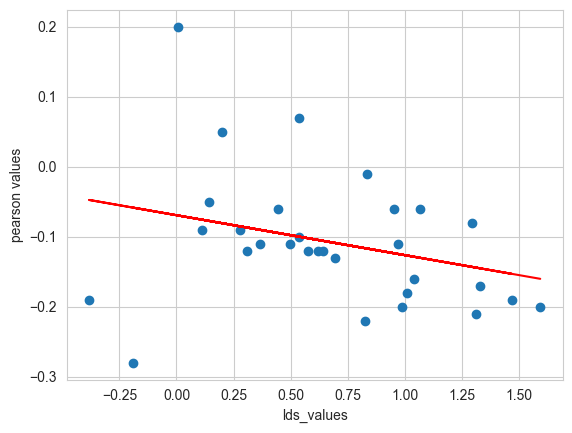

In [43]:
from sklearn.linear_model import LinearRegression
lds_values = merged_df['lds'].values
pearson_values = merged_df['pearson'].values
lds_values = lds_values[:, np.newaxis]

reg_lds = LinearRegression()
reg_lds.fit(lds_values, pearson_values)
predict_lds = reg_lds.predict(lds_values)
plt.plot(lds_values, predict_lds, color='red')
plt.scatter(lds_values, pearson_values)
plt.xlabel('lds_values')
plt.ylabel('pearson values')
plt.show()